In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes


diabetes_dataset = load_diabetes()
print(diabetes_dataset.keys())

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [ ]:
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']
data.shape, targets.shape

((442, 10), (442,))

In [4]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean()) / targets.std()

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split


train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


def get_model():
    model = Sequential([
                        Dense(128, activation='relu', input_shape=(train_data.shape[1], 1)),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(1),
    ])
    return model

In [ ]:
# Print the model summary
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10, 128)           256       
_________________________________________________________________
dense_8 (Dense)              (None, 10, 128)           16512     
_________________________________________________________________
dense_9 (Dense)              (None, 10, 128)           16512     
_________________________________________________________________
dense_10 (Dense)             (None, 10, 128)           16512     
_________________________________________________________________
dense_11 (Dense)             (None, 10, 128)           16512     
_________________________________________________________________
dense_12 (Dense)             (None, 10, 64)            8256      
_________________________________________________________________
dense_13 (Dense)             (None, 10, 1)            

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation
import numpy as np
history = model.fit(train_data[..., np.newaxis], train_targets, epochs=50, validation_split=0.15, batch_size=64, verbose=False)


In [ ]:
# Evaluate the model on the test set
model.evaluate(test_data[..., np.newaxis], test_targets)


2/2 [==============================] - 0s 5ms/step - loss: 0.8980 - mae: 0.8980


[0.8979827761650085, 0.8979827761650085]

#### Plot the learning curves

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

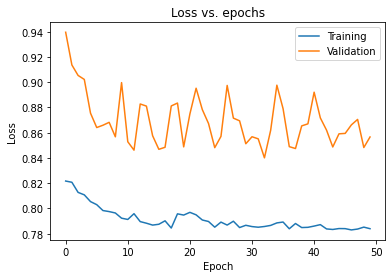

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [8]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [7]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dense(1)
    ])
    return model

In [ ]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [ ]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 5ms/step - loss: 0.6260 - mae: 0.6243


[0.6260254979133606, 0.6242674589157104]

#### Plot the learning curves

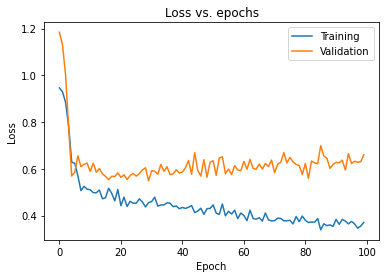

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [9]:
# Write a custom callback 
#  https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
from tensorflow.keras.callbacks import Callback


class TrainingCallback(Callback):
    def on_training_begin(self, logs=None):
        print('Starting training...')
    
    def on_training_end(self, logs=None):
        print('Training Finished')

    def on_epoch_begin(self, epoch, logs=None):
        print(f'Training starting epoch {epoch}')

    def on_epoch_end(self, epoch, logs=None):
        print(f'Training end epoch {epoch}')

    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training starting batch {batch}')

    def on_train_batch_end(self, batch, logs=None):
        print(f'Training end batch {batch}')


class TestingCallback(Callback):
    def on_testing_begin(self, logs=None):
        print('Starting testing...')
    
    def on_training_end(self, logs=None):
        print('Testing Finished')

    def on_test_batch_begin(self, batch, logs=None):
        print(f'Testing starting batch {batch}')

    def on_test_batch_end(self, batch, logs=None):
        print(f'Testing end batch {batch}')


class PredictionCallback(Callback):
    def on_prediction_begin(self, logs=None):
        print('Starting prediction...')
    
    def on_prediction_end(self, logs=None):
        print('prediction Finished')

    def on_prediction_batch_begin(self, batch, logs=None):
        print(f'prediction starting batch {batch}')

    def on_prediction_batch_end(self, batch, logs=None):
        print(f'prediction end batch {batch}')

In [ ]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [ ]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=3, verbose=False, callbacks=[TrainingCallback()], validation_split=0.2)

Training starting epoch 0
Training starting batch 0
Training end batch 0
Training starting batch 1
Training end batch 1
Training starting batch 2
Training end batch 2
Training starting batch 3
Training end batch 3
Training starting batch 4
Training end batch 4
Training starting batch 5
Training end batch 5
Training starting batch 6
Training end batch 6
Training starting batch 7
Training end batch 7
Training starting batch 8
Training end batch 8
Training starting batch 9
Training end batch 9
Training end epoch 0
Training starting epoch 1
Training starting batch 0
Training end batch 0
Training starting batch 1
Training end batch 1
Training starting batch 2
Training end batch 2
Training starting batch 3
Training end batch 3
Training starting batch 4
Training end batch 4
Training starting batch 5
Training end batch 5
Training starting batch 6
Training end batch 6
Training starting batch 7
Training end batch 7
Training starting batch 8
Training end batch 8
Training starting batch 9
Training

In [ ]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Testing starting batch 0
Testing end batch 0
Testing starting batch 1
Testing end batch 1


0.7502024173736572

In [ ]:
# Make predictions with the model
model.predict(test_data, callbacks=[PredictionCallback()], verbose=False)

array([[-0.3809534 ],
       [ 0.6198892 ],
       [ 0.34353328],
       [ 0.4582514 ],
       [ 0.79040146],
       [ 0.75106436],
       [ 0.36090246],
       [-0.33463806],
       [-0.47773623],
       [ 0.14996937],
       [-0.40209258],
       [-0.45523864],
       [ 0.53291434],
       [-0.42407203],
       [ 0.25524276],
       [ 0.5053566 ],
       [ 0.34266946],
       [ 0.5195858 ],
       [ 0.55360836],
       [ 0.30697802],
       [-0.43765226],
       [-0.4285264 ],
       [ 0.46403918],
       [ 0.03245994],
       [-0.34473178],
       [ 0.517493  ],
       [ 0.4276456 ],
       [ 0.58916366],
       [ 0.38946402],
       [-0.4284886 ],
       [-0.30445075],
       [-0.41510814],
       [-0.38745993],
       [ 0.5257668 ],
       [ 0.3784448 ],
       [ 0.20715642],
       [ 0.672851  ],
       [-0.14532456],
       [ 0.4517775 ],
       [ 0.5947476 ],
       [ 0.36204305],
       [ 0.49205545],
       [-0.21605301],
       [ 0.03943986],
       [ 0.26589155]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [29]:
# Re-train the unregularised model
import numpy as np
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mae')
unreg_history = unregularised_model.fit(train_data[...,np.newaxis], train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [30]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data[..., np.newaxis], test_targets, verbose=2)


2/2 - 0s - loss: 0.7867


0.7867022752761841

In [26]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-5, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                        validation_split=0.15, batch_size=64,verbose=False,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [27]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5251


0.5250846743583679

#### Plot the learning curves

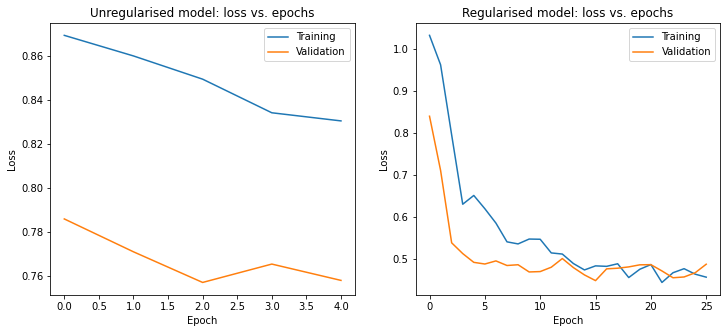

In [31]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()